In [1]:
# [Source for tutorial](https://github.com/pgmpy/pgmpy/blob/dev/examples/Alarm.ipynb)
#
# Alarm Bayesian Network
# Creating the Alarm Bayesian network using pgmpy and doing some simple queries (mentioned in Bayesian Artificial Intelligence, Section 2.5.1: )

In [2]:
# Doing path-setting:

In [3]:
import os
import sys
from typing import *
from typing import Union, List, Any

import itertools

os.getcwd()
# Setting the baseline:
os.chdir('/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP')


curPath: str = os.getcwd() + "/src/PgmpyStudy/"

dataPath: str = curPath + "data/"

imagePath: str = curPath + 'images/'

print("curPath = ", curPath, "\n")
print("dataPath = ", dataPath, "\n")
print('imagePath = ', imagePath, "\n")


# Making files in utils folder visible here: to import my local print functions for nn.Module objects
sys.path.append(os.getcwd() + "/src/utils/")
# For being able to import files within PgmpyStudy folder
sys.path.append(curPath)

sys.path

curPath =  /development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/PgmpyStudy/ 

dataPath =  /development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/PgmpyStudy/data/ 

imagePath =  /development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/PgmpyStudy/images/ 



['/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/PgmpyStudy',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python37.zip',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/lib-dynload',
 '',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages',
 '/development/bin/python/conda3_ana/envs/pybayesian_env/lib/python3.7/site-packages/IPython/extensions',
 '/home/statisticallyfit/.ipython',
 '/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/utils/',
 '/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/PgmpyStudy/']

In [4]:
# Science imports:

In [5]:
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD
from pgmpy.factors.discrete import JointProbabilityDistribution
from pgmpy.factors.discrete.DiscreteFactor import DiscreteFactor
from pgmpy.independencies import Independencies
from pgmpy.independencies.Independencies import IndependenceAssertion


from operator import mul
from functools import reduce


from src.utils.GraphvizUtil import *
from src.utils.NetworkUtil import *

In [6]:
# ## Problem Statement: 2.5.1 Earthquake Alarm
# **Example statement:** You have a new burglar alarm installed. It reliably detects burglary, but also responds to minor earthquakes. Two neighbors, John and Mary, promise to call the police when they hear the alarm. John always calls when he hears the alarm, but sometimes confuses the alarm with the phone ringing and calls then also. On the other hand, Mary likes loud music and sometimes doesn't hear the alarm. Given evidence about who has and hasn't called, you'd like to estimate the probability of a burglary alarm (from Pearl (1988)).
#

In [7]:
# Defining the network structure:
alarmModel: BayesianModel = BayesianModel([('Burglary', 'Alarm'),
                                           ('Earthquake', 'Alarm'),
                                           ('Alarm', 'JohnCalls'),
                                           ('Alarm', 'MaryCalls')])

# Defining parameters using CPT
cpdBurglary: TabularCPD = TabularCPD(variable = 'Burglary', variable_card = 2,
                                     values = [[0.999, 0.001]],
                                     state_names = {'Burglary' : ['False', 'True']})
print(cpdBurglary)
cpdEarthquake: TabularCPD = TabularCPD(variable = 'Earthquake', variable_card = 2,
                                       values = [[0.002, 0.998]],
                                       state_names = {'Earthquake' : ['True', 'False']})

print(cpdEarthquake)

cpdAlarm: TabularCPD = TabularCPD(variable = 'Alarm', variable_card = 2,
                                  values = [[0.95, 0.94, 0.29, 0.001],
                                            [0.05, 0.06, 0.71, 0.999]],
                                  evidence = ['Burglary', 'Earthquake'], evidence_card = [2,2],
                                  state_names = {'Alarm': ['True', 'False'], 'Burglary':['True','False'],'Earthquake': ['True', 'False']})
print(cpdAlarm)

cpdJohnCalls: TabularCPD = TabularCPD(variable = 'JohnCalls', variable_card = 2,
                                      values = [[0.90, 0.05],
                                                [0.10, 0.95]],
                                      evidence = ['Alarm'], evidence_card = [2],
                                      state_names = {'JohnCalls': ['True', 'False'], 'Alarm' : ['True', 'False']})
print(cpdJohnCalls)

cpdMaryCalls: TabularCPD = TabularCPD(variable = 'MaryCalls', variable_card = 2,
                                      values = [[0.70, 0.01],
                                                [0.30, 0.99]],
                                      evidence = ['Alarm'], evidence_card = [2],
                                      state_names = {'MaryCalls': ['True', 'False'], 'Alarm' : ['True', 'False']})
print(cpdMaryCalls)


alarmModel.add_cpds(cpdBurglary, cpdEarthquake, cpdAlarm, cpdJohnCalls, cpdMaryCalls)

assert alarmModel.check_model()

+-----------------+-------+
| Burglary(False) | 0.999 |
+-----------------+-------+
| Burglary(True)  | 0.001 |
+-----------------+-------+
+-------------------+-------+
| Earthquake(True)  | 0.002 |
+-------------------+-------+
| Earthquake(False) | 0.998 |
+-------------------+-------+
+--------------+------------------+-------------------+------------------+-------------------+
| Burglary     | Burglary(True)   | Burglary(True)    | Burglary(False)  | Burglary(False)   |
+--------------+------------------+-------------------+------------------+-------------------+
| Earthquake   | Earthquake(True) | Earthquake(False) | Earthquake(True) | Earthquake(False) |
+--------------+------------------+-------------------+------------------+-------------------+
| Alarm(True)  | 0.95             | 0.94              | 0.29             | 0.001             |
+--------------+------------------+-------------------+------------------+-------------------+
| Alarm(False) | 0.05             | 0.06     

In [8]:
# Making a brief-name version for viewing clarity, in tables:

In [9]:
alarmModel_brief: BayesianModel = BayesianModel([('B', 'A'),
                                                 ('E', 'A'),
                                                 ('A', 'J'),
                                                 ('A', 'M')])

# Defining parameters using CPT
cpdBurglary: TabularCPD = TabularCPD(variable = 'B', variable_card = 2,
                                     values = [[0.999, 0.001]],
                                     state_names = {'B' : ['False', 'True']})

cpdEarthquake: TabularCPD = TabularCPD(variable = 'E', variable_card = 2,
                                       values = [[0.002, 0.998]],
                                       state_names = {'E' : ['True', 'False']})

cpdAlarm: TabularCPD = TabularCPD(variable = 'A', variable_card = 2,
                                  values = [[0.95, 0.94, 0.29, 0.001],
                                            [0.05, 0.06, 0.71, 0.999]],
                                  evidence = ['B', 'E'], evidence_card = [2,2],
                                  state_names = {'A': ['True', 'False'], 'B':['True','False'],'E': ['True', 'False']})


cpdJohnCalls: TabularCPD = TabularCPD(variable = 'J', variable_card = 2,
                                      values = [[0.90, 0.05],
                                                [0.10, 0.95]],
                                      evidence = ['A'], evidence_card = [2],
                                      state_names = {'J': ['True', 'False'], 'A' : ['True', 'False']})


cpdMaryCalls: TabularCPD = TabularCPD(variable = 'M', variable_card = 2,
                                      values = [[0.70, 0.01],
                                                [0.30, 0.99]],
                                      evidence = ['A'], evidence_card = [2],
                                      state_names = {'M': ['True', 'False'], 'A' : ['True', 'False']})


alarmModel_brief.add_cpds(cpdBurglary, cpdEarthquake, cpdAlarm, cpdJohnCalls, cpdMaryCalls)

assert alarmModel_brief.check_model()

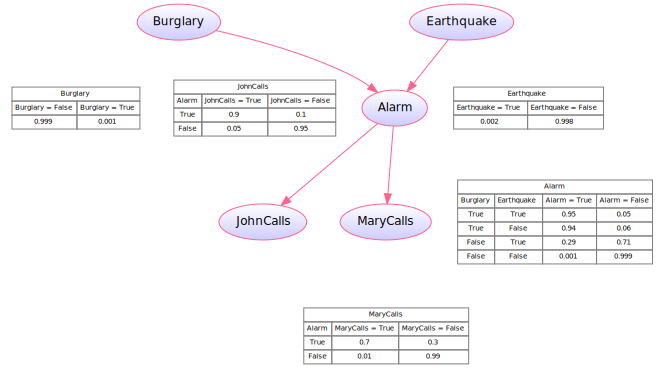

In [10]:
pgmpyToGraphCPD(model = alarmModel, shorten = False)

In [11]:
# ## 1/ Independencies of the Alarm Model

In [12]:
alarmModel.local_independencies('Burglary')

(Burglary _|_ Earthquake)

In [13]:
alarmModel.local_independencies('Earthquake')

(Earthquake _|_ Burglary)

In [14]:
alarmModel.local_independencies('Alarm')

In [15]:
print(alarmModel.local_independencies('MaryCalls'))

indepSynonymTable(model = alarmModel, queryNode = 'MaryCalls')

(MaryCalls _|_ Burglary, JohnCalls, Earthquake | Alarm)
                                                       INDEPENDENCIES TABLE                                                      
Fancy Notation                                                  .....     Regular Notation                                       
---------------------------------------------------------------------------------------------------------------------------------
(MaryCalls _|_ {Burglary ∩ JohnCalls ∩ Earthquake} | Alarm)     .....     (MaryCalls _|_ Burglary, JohnCalls, Earthquake | Alarm)
(MaryCalls _|_ {Burglary ∩ Earthquake ∩ JohnCalls} | Alarm)     .....     (MaryCalls _|_ Burglary, Earthquake, JohnCalls | Alarm)
(MaryCalls _|_ {JohnCalls ∩ Burglary ∩ Earthquake} | Alarm)     .....     (MaryCalls _|_ JohnCalls, Burglary, Earthquake | Alarm)
(MaryCalls _|_ {JohnCalls ∩ Earthquake ∩ Burglary} | Alarm)     .....     (MaryCalls _|_ JohnCalls, Earthquake, Burglary | Alarm)
(MaryCalls _|_ {Earthquake ∩ Burgl

In [16]:
print(alarmModel.local_independencies('JohnCalls'))

indepSynonymTable(model = alarmModel, queryNode = 'JohnCalls')

(JohnCalls _|_ Burglary, MaryCalls, Earthquake | Alarm)
                                                       INDEPENDENCIES TABLE                                                      
Fancy Notation                                                  .....     Regular Notation                                       
---------------------------------------------------------------------------------------------------------------------------------
(JohnCalls _|_ {Burglary ∩ MaryCalls ∩ Earthquake} | Alarm)     .....     (JohnCalls _|_ Burglary, MaryCalls, Earthquake | Alarm)
(JohnCalls _|_ {Burglary ∩ Earthquake ∩ MaryCalls} | Alarm)     .....     (JohnCalls _|_ Burglary, Earthquake, MaryCalls | Alarm)
(JohnCalls _|_ {MaryCalls ∩ Burglary ∩ Earthquake} | Alarm)     .....     (JohnCalls _|_ MaryCalls, Burglary, Earthquake | Alarm)
(JohnCalls _|_ {MaryCalls ∩ Earthquake ∩ Burglary} | Alarm)     .....     (JohnCalls _|_ MaryCalls, Earthquake, Burglary | Alarm)
(JohnCalls _|_ {Earthquake ∩ Burgl

In [17]:
alarmModel.get_independencies()



(Burglary _|_ Earthquake)
(Burglary _|_ JohnCalls, MaryCalls | Alarm)
(Burglary _|_ MaryCalls | JohnCalls, Alarm)
(Burglary _|_ JohnCalls | MaryCalls, Alarm)
(Burglary _|_ JohnCalls, MaryCalls | Alarm, Earthquake)
(Burglary _|_ MaryCalls | JohnCalls, Alarm, Earthquake)
(Burglary _|_ JohnCalls | MaryCalls, Alarm, Earthquake)
(Earthquake _|_ Burglary)
(Earthquake _|_ JohnCalls, MaryCalls | Alarm)
(Earthquake _|_ JohnCalls, MaryCalls | Burglary, Alarm)
(Earthquake _|_ JohnCalls | MaryCalls, Alarm)
(Earthquake _|_ MaryCalls | JohnCalls, Alarm)
(Earthquake _|_ JohnCalls | Burglary, Alarm, MaryCalls)
(Earthquake _|_ MaryCalls | Burglary, Alarm, JohnCalls)
(JohnCalls _|_ Burglary, MaryCalls, Earthquake | Alarm)
(JohnCalls _|_ MaryCalls, Earthquake | Burglary, Alarm)
(JohnCalls _|_ Burglary, Earthquake | MaryCalls, Alarm)
(JohnCalls _|_ Burglary, MaryCalls | Alarm, Earthquake)
(JohnCalls _|_ Earthquake | Burglary, Alarm, MaryCalls)
(JohnCalls _|_ MaryCalls | Burglary, Alarm, Earthquake)
(JohnC

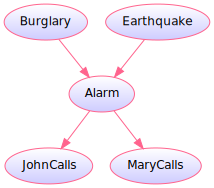

In [18]:
# TODO say direct dependency assumptions (from Korb book)

pgmpyToGraph(alarmModel)

In [19]:
# ### Study: Independence Maps (I-Maps)
# * **Markov Assumption:** Bayesian networks require the assumption of **Markov Property**: that there are no direct dependencies in the system being modeled, which are not already explicitly shown via arcs. (In the earthquake example, this translates to saying there is no way for an `Earthquake` to influence `MaryCalls` except by way of the `Alarm`.  There is no **hidden backdoor** from  `Earthquake` to `MaryCalls`).
# * **I-maps:** Bayesian networks which have this **Markov property** are called **Independence-maps** or **I-maps**, since every independence suggested by the lack of an arc is actual a valid, real independence in the system.
#
# Source: Korb book, Bayesian Artificial Intelligence (section 2.2.4)

In [20]:
# ### Example 1: I-map
# Testing meaning of an **I-map** using a simple student example

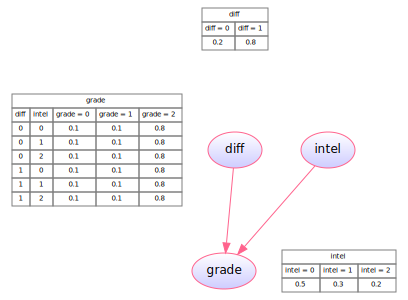

In [21]:

gradeModel = BayesianModel([('diff', 'grade'), ('intel', 'grade')])

diff_cpd = TabularCPD('diff', 2, [[0.2], [0.8]])
intel_cpd = TabularCPD('intel', 3, [[0.5], [0.3], [0.2]])
grade_cpd = TabularCPD('grade', 3, [[0.1,0.1,0.1,0.1,0.1,0.1],
                                    [0.1,0.1,0.1,0.1,0.1,0.1],
                                    [0.8,0.8,0.8,0.8,0.8,0.8]],
                       evidence=['diff', 'intel'], evidence_card=[2, 3])

gradeModel.add_cpds(diff_cpd, intel_cpd, grade_cpd)


pgmpyToGraphCPD(gradeModel)

In [22]:
# Showing two ways of creating the `JointProbabilityDistribution`    : (1) by feeding in values manually, or (2) by using `reduce` over the `TabularCPD`s or `DiscreteFactor`s.

In [23]:
# Method 1: Creating joint distribution manually, by feeding in the calculated values:
jpdValues = [0.01, 0.01, 0.08, 0.006, 0.006, 0.048, 0.004, 0.004, 0.032,
           0.04, 0.04, 0.32, 0.024, 0.024, 0.192, 0.016, 0.016, 0.128]

JPD = JointProbabilityDistribution(variables = ['diff', 'intel', 'grade'], cardinality = [2, 3, 3], values = jpdValues)

print(JPD)

+---------+----------+----------+-----------------------+
| diff    | intel    | grade    |   P(diff,intel,grade) |
+=========+==========+==========+=======================+
| diff(0) | intel(0) | grade(0) |                0.0100 |
+---------+----------+----------+-----------------------+
| diff(0) | intel(0) | grade(1) |                0.0100 |
+---------+----------+----------+-----------------------+
| diff(0) | intel(0) | grade(2) |                0.0800 |
+---------+----------+----------+-----------------------+
| diff(0) | intel(1) | grade(0) |                0.0060 |
+---------+----------+----------+-----------------------+
| diff(0) | intel(1) | grade(1) |                0.0060 |
+---------+----------+----------+-----------------------+
| diff(0) | intel(1) | grade(2) |                0.0480 |
+---------+----------+----------+-----------------------+
| diff(0) | intel(2) | grade(0) |                0.0040 |
+---------+----------+----------+-----------------------+
| diff(0) | in

In [24]:
# Showing if small student model is I-map:

In [25]:
from src.utils.NetworkUtil import *


# Method 2: creating the JPD by multiplying over the TabularCPDs (as per formula in page 16 of pgmpy book, Ankur Ankan)
gradeJPDFactor: DiscreteFactor = DiscreteFactor(variables = JPD.variables, cardinality =  JPD.cardinality, values = JPD.values)
gradeJPD: JointProbabilityDistribution = jointDistribution(gradeModel)


assert gradeModel.is_imap(JPD = JPD), "Check: using JPD to verify the graph is an independence-map: means no hidden backdoors between nodes and no way for variables to influence others except by one path"

assert gradeJPD == gradeJPDFactor, "Check: joint distribution is the same as multiplying the cpds"

In [26]:
# Grade model's `JointProbabilityDistribution` over all variables:

In [27]:
print(gradeJPD)

+---------+----------+----------+-----------------------+
| diff    | intel    | grade    |   P(diff,intel,grade) |
+=========+==========+==========+=======================+
| diff(0) | intel(0) | grade(0) |                0.0100 |
+---------+----------+----------+-----------------------+
| diff(0) | intel(0) | grade(1) |                0.0100 |
+---------+----------+----------+-----------------------+
| diff(0) | intel(0) | grade(2) |                0.0800 |
+---------+----------+----------+-----------------------+
| diff(0) | intel(1) | grade(0) |                0.0060 |
+---------+----------+----------+-----------------------+
| diff(0) | intel(1) | grade(1) |                0.0060 |
+---------+----------+----------+-----------------------+
| diff(0) | intel(1) | grade(2) |                0.0480 |
+---------+----------+----------+-----------------------+
| diff(0) | intel(2) | grade(0) |                0.0040 |
+---------+----------+----------+-----------------------+
| diff(0) | in

In [28]:
# Checking if alarm model is I-map:

In [29]:
alarmJPD: JointProbabilityDistribution = jointDistribution(alarmModel_brief)

assert not alarmModel_brief.is_imap(JPD = alarmJPD)





## 3/ Joint Distribution Represented by the Bayesian Network
Computing the Joint Distribution from the Bayesian Network, `model`:

From the **chain rule of probability (also called and rule):**
$$
P(A, B) = P(B) \cdot P(A \; | \; B)
$$
Now in this case for the `alarmModel`:
$$
\begin{align}
P(J, M, A, E, B)
&= P(J \; | \; M, A, E, B) \cdot P(J, M, A, E, B) \\
&= P(J \; | \; M, A, E, B) \cdot {\color{cyan} (} P(M \; | \; A,E,B) \cdot P(A,E,B) {\color{cyan} )} \\
&=  P(J \; | \; M, A, E, B) \cdot  P(M \; | \; A,E,B) \cdot {\color{cyan} (}P(A \; | \; E,B) \cdot P(E, B){\color{cyan} )} \\
&= P(J \; | \; M, A, E, B) \cdot  P(M \; | \; A,E,B) \cdot P(A \; | \; E,B) \cdot {\color{cyan} (}P(E \; | \; B) \cdot P(B){\color{cyan} )} \\
\end{align}
$$

In [30]:
probChainRule(['J','M','A','E','B'])

'P(J | M, A, E, B) * P(M | A, E, B) * P(A | E, B) * P(E | B) * P(B)'

In [31]:
# Alarm model's `JointProbabilityDistribution` over all variables

In [32]:
print(alarmJPD)




+------+------+------+------+------+----------------+
| B    | E    | A    | J    | M    |   P(B,E,A,J,M) |
+======+======+======+======+======+================+
| B(0) | E(0) | A(0) | J(0) | M(0) |         0.0012 |
+------+------+------+------+------+----------------+
| B(0) | E(0) | A(0) | J(0) | M(1) |         0.0005 |
+------+------+------+------+------+----------------+
| B(0) | E(0) | A(0) | J(1) | M(0) |         0.0001 |
+------+------+------+------+------+----------------+
| B(0) | E(0) | A(0) | J(1) | M(1) |         0.0001 |
+------+------+------+------+------+----------------+
| B(0) | E(0) | A(1) | J(0) | M(0) |         0.0000 |
+------+------+------+------+------+----------------+
| B(0) | E(0) | A(1) | J(0) | M(1) |         0.0000 |
+------+------+------+------+------+----------------+
| B(0) | E(0) | A(1) | J(1) | M(0) |         0.0000 |
+------+------+------+------+------+----------------+
| B(0) | E(0) | A(1) | J(1) | M(1) |         0.0001 |
+------+------+------+------

## 4/ Inference in Bayesian Alarm Model
So far we talked about represented Bayesian Networks.

Now let us do inference in a  Bayesian model and predict values using this model over new data points for ML tasks.

### 1. Causal Reasoning in the Alarm Model
For a causal model $A \rightarrow B \rightarrow C$, there are two cases:
  * **Marginal Dependence:** ($B$ unknown): When $B$ is unknown / unobserved, there is an active trail between $A$
  and $C$, meaning the probability of $A$ can influence probability of $C$ (and vice versa) when information about $B$'s state is unknown.
  * **Conditional Independence:** ($B$ fixed): When $B$ is fixed, there is NO active trail between $A$ and $C$,
  so they are independent. The probability of $A$ won't influence probability of $C$ (and vice versa) when $B$'s state is observed.

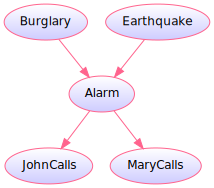

In [33]:
pgmpyToGraph(alarmModel)

$\color{MediumVioletRed}{\text{Case 1: Marginal Dependence (for Causal Model)}}$

$$
\color{Green}{ \text{Alarm (unknown): }\;\;\;\;\;\;\;\;\; \text{Burglary} \longrightarrow \text{Alarm} \longrightarrow \text{MaryCalls}}
$$

When the middle node `Alarm` is unknown / unobserved, there IS an active trail between `Burglary` and `MaryCalls`. In other words, there is a dependence between `Burglary` and `MaryCalls` when `Alarm` is unobserved. This means the probability of `Burglary` can influence probability of `MaryCalls` (and vice versa) when information about `Alarm`'s state is unknown.


$$
\color{Green}{ \text{Alarm (unknown): }\;\;\;\;\;\;\;\;\; \text{Burglary} \longrightarrow \text{Alarm} \longrightarrow \text{JohnCalls}}
$$
When `Alarm`'s state is uknown, there is an active trail or dependency between `Burglary` and `JohnCalls`, so the probability of `Burglary` can influence the probability of `JohnCalls` (and vice versa) when `Alarm`'s state is unknown.

$$
\color{Green}{ \text{Alarm (unknown): }\;\;\;\;\;\;\;\;\; \text{Earthquake} \longrightarrow \text{Alarm} \longrightarrow \text{MaryCalls}}
$$
When `Alarm`'s state is uknown, there is an active trail or dependency between `Earthquake` and `MaryCalls`, so the probability of `Earthquake` can influence the probability of `MaryCalls` (and vice versa) when `Alarm`'s state is unknown.

$$
\color{Green}{ \text{Alarm (unknown): }\;\;\;\;\;\;\;\;\; \text{Earthquake} \longrightarrow \text{Alarm} \longrightarrow \text{JohnCalls}}
$$
When `Alarm`'s state is uknown, there is an active trail or dependency between `Earthquake` and `JohnCalls`, so the probability of `Earthquake` can influence the probability of `JohnCalls` (and vice versa) when `Alarm`'s state is unknown.

In [34]:
# **Verify:** Using Active Trails

In [35]:
assert alarmModel.is_active_trail(start = 'Burglary', end = 'MaryCalls', observed = None)
assert alarmModel.is_active_trail(start = 'Burglary', end = 'JohnCalls', observed = None)
assert alarmModel.is_active_trail(start = 'Earthquake', end = 'MaryCalls', observed = None)
assert alarmModel.is_active_trail(start = 'Earthquake', end = 'JohnCalls', observed = None)

showActiveTrails(model = alarmModel, variables = ['Burglary', 'MaryCalls'])

Burglary --> Burglary
Burglary --> Alarm
Burglary --> MaryCalls
Burglary --> JohnCalls
MaryCalls --> Burglary
MaryCalls --> Earthquake
MaryCalls --> JohnCalls
MaryCalls --> Alarm
MaryCalls --> MaryCalls


In [36]:
elim: VariableElimination = VariableElimination(model = alarmModel)

In [37]:
# **Verify:** Using Probabilities (example of $B \rightarrow A \rightarrow J$ trail)
# ##### Inter-Causal Reasoning For Causal Model:

In [38]:
BAJ: DiscreteFactor = elim.query(variables = ['JohnCalls'], evidence = None)
print(BAJ)

  0%|          | 0/4 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/4 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 4/4 [00:00<00:00, 759.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/4 [00:00<?, ?it/s]    

Eliminating: Earthquake:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: Earthquake: 100%|██████████| 4/4 [00:00<00:00, 176.10it/s]

+------------------+------------------+
| JohnCalls        |   phi(JohnCalls) |
+==================+==================+
| JohnCalls(True)  |           0.8482 |
+------------------+------------------+
| JohnCalls(False) |           0.1518 |
+------------------+------------------+


In [39]:
# When there has been burglary and no Alarm was observed, there is a higher probability of John calling, compared to when no burglary was observed and no alarm was observed. (above)
BAJ_1 = elim.query(variables = ['JohnCalls'], evidence = {'Burglary':'True'})
print(BAJ_1)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 675.16it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/3 [00:00<?, ?it/s]    

Eliminating: Earthquake:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Earthquake: 100%|██████████| 3/3 [00:00<00:00, 167.72it/s]

+------------------+------------------+
| JohnCalls        |   phi(JohnCalls) |
+==================+==================+
| JohnCalls(True)  |           0.8490 |
+------------------+------------------+
| JohnCalls(False) |           0.1510 |
+------------------+------------------+


In [40]:
# When there was no burglary and no alarm was observed, there is a lower probability of John calling than when no burglary and alarm were observed (first case)
BAJ_2 = elim.query(variables = ['JohnCalls'], evidence = {'Burglary':'False'})
print(BAJ_2)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 463.49it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/3 [00:00<?, ?it/s]    

Eliminating: Earthquake:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Earthquake: 100%|██████████| 3/3 [00:00<00:00, 182.91it/s]

+------------------+------------------+
| JohnCalls        |   phi(JohnCalls) |
+==================+==================+
| JohnCalls(True)  |           0.0513 |
+------------------+------------------+
| JohnCalls(False) |           0.9487 |
+------------------+------------------+


In [41]:
assert (BAJ.values != BAJ_1.values).all() and (BAJ.values != BAJ_2.values).all(), "Check there is dependency between Burglary and JohnCalls, when Alarm state is unobserved "

In [42]:
# **Verify:** Using Probabilities (example of $E \rightarrow A \rightarrow M$ trail)
# ##### Inter-Causal Reasoning For Causal Model:

In [43]:
EAM: DiscreteFactor = elim.query(variables = ['MaryCalls'], evidence = None)
print(EAM)

  0%|          | 0/4 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/4 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 4/4 [00:00<00:00, 577.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/4 [00:00<?, ?it/s]    

Eliminating: Earthquake:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: Earthquake: 100%|██████████| 4/4 [00:00<00:00, 130.24it/s]

+------------------+------------------+
| MaryCalls        |   phi(MaryCalls) |
+==================+==================+
| MaryCalls(True)  |           0.6580 |
+------------------+------------------+
| MaryCalls(False) |           0.3420 |
+------------------+------------------+


In [44]:
# When there has been earthquake and no Alarm was observed, there is a higher probability of Mary calling, compared to when there was no earthquake and no alarm was observed. (above)
EAM_1 = elim.query(variables = ['MaryCalls'], evidence = {'Earthquake':'True'})
print(EAM_1)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 763.43it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/3 [00:00<?, ?it/s]    

Eliminating: Alarm: 100%|██████████| 3/3 [00:00<00:00, 180.94it/s]

+------------------+------------------+
| MaryCalls        |   phi(MaryCalls) |
+==================+==================+
| MaryCalls(True)  |           0.6650 |
+------------------+------------------+
| MaryCalls(False) |           0.3350 |
+------------------+------------------+


In [45]:
# When there was no earthquake and no alarm was observed, there is a lower probability (??) of Mary calling than when there was no earthquake and no alarm  observed
EAM_2 = elim.query(variables = ['MaryCalls'], evidence = {'Earthquake':'False'})
print(EAM_2)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 654.64it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/3 [00:00<?, ?it/s]    

Eliminating: Alarm: 100%|██████████| 3/3 [00:00<00:00, 241.04it/s]

+------------------+------------------+
| MaryCalls        |   phi(MaryCalls) |
+==================+==================+
| MaryCalls(True)  |           0.6580 |
+------------------+------------------+
| MaryCalls(False) |           0.3420 |
+------------------+------------------+


In [46]:
assert (EAM.values != EAM_1.values).all() and (EAM.values != EAM_2.values).all(), "Check there is dependency between Earthquake and MaryCalls, when Alarm state is unobserved "




$\color{MediumVioletRed}{\text{Case 2: Conditional Independence (for Causal Model)}}$

$$
\color{DeepSkyBlue}{ \text{Alarm (fixed): }\;\;\;\;\;\;\;\; \text{Burglary} \; \bot \; \text{MaryCalls} \; | \; \text{Alarm}}
$$
When the `Alarm`'s state is known (fixed / observed), then there is NO active trail between `Burglary` and `MaryCalls`. In other words, `Burglary` and `MaryCalls` are locally independent when `Alarm`'s state is observed. This means the probability of `Burglary` won't influence probability of `MaryCalls` (and vice versa) when `Alarm`'s state is observed.

$$
\color{DeepSkyBlue}{ \text{Alarm (fixed): }\;\;\;\;\;\;\;\; \text{Burglary} \; \bot \; \text{JohnCalls} \; | \; \text{Alarm}}
$$
When the `Alarm`'s state is known (fixed / observed), then there is NO active trail between `Burglary` and `JohnCalls`. In other words, `Burglary` and `JohnCalls` are locally independent when `Alarm`'s state is observed. This means the probability of `Burglary` won't influence probability of `JohnCalls` (and vice versa) when `Alarm`'s state is observed.

$$
\color{DeepSkyBlue}{ \text{Alarm (fixed): }\;\;\;\;\;\;\;\; \text{Earthquake} \; \bot \; \text{MaryCalls} \; | \; \text{Alarm}}
$$
When the `Alarm`'s state is known (fixed / observed), then there is NO active trail between `Earthquake` and `MaryCalls`. In other words, `Earthquake` and `MaryCalls` are locally independent when `Alarm`'s state is observed. This means the probability of `Earthquake` won't influence probability of `MaryCalls` (and vice versa) when `Alarm`'s state is observed.

$$
\color{DeepSkyBlue}{ \text{Alarm (fixed): }\;\;\;\;\;\;\;\; \text{Earthquake} \; \bot \; \text{JohnCalls} \; | \; \text{Alarm}}
$$
When the `Alarm`'s state is known (fixed / observed), then there is NO active trail between `Earthquake` and `JohnCalls`. In other words, `Earthquake` and `JohnCalls` are locally independent when `Alarm`'s state is observed. This means the probability of `Earthquake` won't influence probability of `JohnCalls` (and vice versa) when `Alarm`'s state is observed.

In [47]:
# **Verify:** Using Active Trails

In [48]:
assert not alarmModel.is_active_trail(start = 'Burglary', end = 'MaryCalls', observed = 'Alarm')
assert not alarmModel.is_active_trail(start = 'Burglary', end = 'JohnCalls', observed = 'Alarm')
assert not alarmModel.is_active_trail(start = 'Earthquake', end = 'MaryCalls', observed = 'Alarm')
assert not alarmModel.is_active_trail(start = 'Earthquake', end = 'JohnCalls', observed = 'Alarm')

showActiveTrails(model = alarmModel, variables = ['Burglary', 'MaryCalls'], observed = 'Alarm')

Burglary --> Burglary
Burglary --> Earthquake
MaryCalls --> MaryCalls


In [49]:
# **Verify:** Using Independencies (just the $(B \; \bot \; M \; | \; A)$ independence)

In [50]:
indepBurglary: IndependenceAssertion = Independencies(['Burglary', 'MaryCalls', ['Alarm']]).get_assertions()[0]; indepBurglary

indepMary: IndependenceAssertion = Independencies(['MaryCalls', 'Burglary', ['Alarm']]).get_assertions()[0]; indepMary

# Using the fact that closure returns independencies that are IMPLIED by the current independencies:
assert (str(indepMary) == '(MaryCalls _|_ Burglary | Alarm)' and
        indepMary in alarmModel.local_independencies('MaryCalls').closure().get_assertions()),  \
        "Check 1: Burglary and MaryCalls are independent once conditional on Alarm"

assert (str(indepBurglary) == '(Burglary _|_ MaryCalls | Alarm)' and
        indepBurglary in alarmModel.local_independencies('MaryCalls').closure().get_assertions()), \
        "Check 2: Burglary and MaryCalls are independent once conditional on Alarm"

alarmModel.local_independencies('MaryCalls').closure()

(MaryCalls _|_ Burglary, Earthquake | JohnCalls, Alarm)
(MaryCalls _|_ Burglary, JohnCalls | Alarm, Earthquake)
(MaryCalls _|_ JohnCalls | Burglary, Alarm, Earthquake)
(MaryCalls _|_ Burglary, JohnCalls, Earthquake | Alarm)
(MaryCalls _|_ Earthquake | Burglary, Alarm)
(MaryCalls _|_ Burglary | JohnCalls, Alarm, Earthquake)
(MaryCalls _|_ Burglary | JohnCalls, Alarm)
(MaryCalls _|_ Burglary | Alarm)
(MaryCalls _|_ Earthquake | Alarm)
(MaryCalls _|_ Earthquake | JohnCalls, Alarm)
(MaryCalls _|_ Burglary | Alarm, Earthquake)
(MaryCalls _|_ JohnCalls | Burglary, Alarm)
(MaryCalls _|_ Burglary, Earthquake | Alarm)
(MaryCalls _|_ Earthquake | Burglary, Alarm, JohnCalls)
(MaryCalls _|_ JohnCalls, Earthquake | Burglary, Alarm)
(MaryCalls _|_ JohnCalls | Alarm)
(MaryCalls _|_ Burglary, JohnCalls | Alarm)
(MaryCalls _|_ JohnCalls | Alarm, Earthquake)
(MaryCalls _|_ JohnCalls, Earthquake | Alarm)

In [51]:
# See: MaryCalls and Burglary are conditionally independent on Alarm:
indepSynonymTable(model = alarmModel_brief, queryNode = 'M')



                   INDEPENDENCIES TABLE                  
Fancy Notation              .....     Regular Notation   
---------------------------------------------------------
(M _|_ {J ∩ E ∩ B} | A)     .....     (M _|_ J, E, B | A)
(M _|_ {J ∩ B ∩ E} | A)     .....     (M _|_ J, B, E | A)
(M _|_ {E ∩ J ∩ B} | A)     .....     (M _|_ E, J, B | A)
(M _|_ {E ∩ B ∩ J} | A)     .....     (M _|_ E, B, J | A)
(M _|_ {B ∩ J ∩ E} | A)     .....     (M _|_ B, J, E | A)
(M _|_ {B ∩ E ∩ J} | A)     .....     (M _|_ B, E, J | A)


In [52]:
# **Verify:** Using Probabilities Method (just the $(E \; \bot \; J \; | \; A)$ independence)

In [53]:

# Case 1: Alarm = True
EAJ: DiscreteFactor = elim.query(variables = ['JohnCalls'], evidence = {'Alarm': 'True'})
EAJ_1 = elim.query(variables = ['JohnCalls'], evidence = {'Alarm': 'True', 'Earthquake':'True'})
EAJ_2 = elim.query(variables = ['JohnCalls'], evidence = {'Alarm': 'True', 'Earthquake':'False'})

assert (EAJ.values == EAJ_1.values).all() and (EAJ.values == EAJ_2.values).all(), "Check: there is independence between Earthquake and JohnCalls when Alarm state is observed (Alarm = True)"

print(EAJ)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 859.08it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Earthquake: 100%|██████████| 3/3 [00:00<00:00, 108.54it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 182.96it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls: 100%|██████████| 2/2 [00:00<00:00, 217.90it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 358.81it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls: 100%|██████████| 2/2 [00:00<00:00, 213.12it/s]

+------------------+------------------+
| JohnCalls        |   phi(JohnCalls) |
+==================+==================+
| JohnCalls(True)  |           0.9000 |
+------------------+------------------+
| JohnCalls(False) |           0.1000 |
+------------------+------------------+


In [54]:
# Case 2: Alarm = False
EAJ: DiscreteFactor = elim.query(variables = ['JohnCalls'], evidence = {'Alarm': 'False'})
EAJ_1 = elim.query(variables = ['JohnCalls'], evidence = {'Alarm': 'False', 'Earthquake':'True'})
EAJ_2 = elim.query(variables = ['JohnCalls'], evidence = {'Alarm': 'False', 'Earthquake':'False'})

assert (EAJ.values == EAJ_1.values).all() and (EAJ.values == EAJ_2.values).all(), "Check: there is independence between Earthquake and JohnCalls when Alarm state is observed (Alarm = False)"

print(EAJ)









  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 496.27it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Earthquake: 100%|██████████| 3/3 [00:00<00:00, 239.28it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 367.04it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls: 100%|██████████| 2/2 [00:00<00:00, 254.82it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 614.91it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls: 100%|██████████| 2/2 [00:00<00:00, 255.62it/s]

+------------------+------------------+
| JohnCalls        |   phi(JohnCalls) |
+==================+==================+
| JohnCalls(True)  |           0.0500 |
+------------------+------------------+
| JohnCalls(False) |           0.9500 |
+------------------+------------------+


In [55]:
# ### 2. Evidential Reasoning in the Alarm Model
# For an evidential model $A \leftarrow B \leftarrow C$, there are two cases:
#   * **Marginal Dependence:** ($B$ unknown): When $B$ is unknown / unobserved, there is an active trail between $A$
#   and $C$, meaning the probability of $A$ can influence probability of $C$ (and vice versa) when information about $B$'s state is unknown.
#   * **Conditional Independence:** ($B$ fixed): When $B$ is fixed, there is NO active trail between $A$ and $C$,
#   so they are independent. The probability of $A$ won't influence probability of $C$ (and vice versa) when $B$'s state is observed.

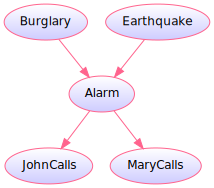

In [56]:
pgmpyToGraph(alarmModel)

$\color{MediumVioletRed}{\text{Case 1: Marginal Dependence (for Evidential Model)}}$

$$
\color{Green}{ \text{Alarm (unknown): }\;\;\;\;\;\;\;\;\; \text{Burglary} \longleftarrow \text{Alarm} \longleftarrow
\text{MaryCalls}}
$$

When the middle node `Alarm` is unknown / unobserved, there IS an active trail between `Burglary` and `MaryCalls`. In other words, there is a dependence between `Burglary` and `MaryCalls` when `Alarm` is unobserved. This means the probability of `Burglary` can influence probability of `MaryCalls` (and vice versa) when information about `Alarm`'s state is unknown.


$$
\color{Green}{ \text{Alarm (unknown): }\;\;\;\;\;\;\;\;\; \text{Burglary} \longleftarrow \text{Alarm} \longleftarrow \text{JohnCalls}}
$$
When `Alarm`'s state is uknown, there is an active trail or dependency between `Burglary` and `JohnCalls`, so the probability of `Burglary` can influence the probability of `JohnCalls` (and vice versa) when `Alarm`'s state is unknown.

$$
\color{Green}{ \text{Alarm (unknown): }\;\;\;\;\;\;\;\;\; \text{Earthquake} \longleftarrow \text{Alarm} \longleftarrow \text{MaryCalls}}
$$
When `Alarm`'s state is uknown, there is an active trail or dependency between `Earthquake` and `MaryCalls`, so the probability of `Earthquake` can influence the probability of `MaryCalls` (and vice versa) when `Alarm`'s state is unknown.

$$
\color{Green}{ \text{Alarm (unknown): }\;\;\;\;\;\;\;\;\; \text{Earthquake} \longleftarrow \text{Alarm} \longleftarrow \text{JohnCalls}}
$$
When `Alarm`'s state is uknown, there is an active trail or dependency between `Earthquake` and `JohnCalls`, so the probability of `Earthquake` can influence the probability of `JohnCalls` (and vice versa) when `Alarm`'s state is unknown.

In [57]:
# **Verify:** Using Active Trails

In [58]:
assert alarmModel.is_active_trail(start = 'MaryCalls', end = 'Burglary',  observed = None)
assert alarmModel.is_active_trail(start = 'MaryCalls', end = 'Earthquake', observed = None)
assert alarmModel.is_active_trail(start = 'JohnCalls', end = 'Burglary', observed = None)
assert alarmModel.is_active_trail(start = 'JohnCalls', end = 'Earthquake', observed = None)

showActiveTrails(model = alarmModel, variables = ['MaryCalls', 'Burglary'])

MaryCalls --> Burglary
MaryCalls --> Earthquake
MaryCalls --> JohnCalls
MaryCalls --> Alarm
MaryCalls --> MaryCalls
Burglary --> Burglary
Burglary --> Alarm
Burglary --> MaryCalls
Burglary --> JohnCalls


In [59]:
# **Verify:** Using Probabilities (example of $B \leftarrow A \leftarrow J$ trail)
# ##### Inter-Causal Reasoning For Evidential Model:

In [60]:
JAB: DiscreteFactor = elim.query(variables = ['Burglary'], evidence = None)
print(JAB)

  0%|          | 0/4 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/4 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 4/4 [00:00<00:00, 730.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/4 [00:00<?, ?it/s]    

Eliminating: MaryCalls:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: Earthquake: 100%|██████████| 4/4 [00:00<00:00, 166.44it/s]

+-----------------+-----------------+
| Burglary        |   phi(Burglary) |
+=================+=================+
| Burglary(False) |          0.9990 |
+-----------------+-----------------+
| Burglary(True)  |          0.0010 |
+-----------------+-----------------+


In [61]:
# When John has called and no Alarm was observed, there is a lower probability of Burglary, compared to when no call from John is observed and no alarm was observed. (above)
JAB_1 = elim.query(variables = ['Burglary'], evidence = {'JohnCalls':'True'})
print(JAB_1)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 897.18it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/3 [00:00<?, ?it/s]    

Eliminating: Earthquake:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Earthquake: 100%|██████████| 3/3 [00:00<00:00, 144.51it/s]

+-----------------+-----------------+
| Burglary        |   phi(Burglary) |
+=================+=================+
| Burglary(False) |          0.9999 |
+-----------------+-----------------+
| Burglary(True)  |          0.0001 |
+-----------------+-----------------+


In [62]:
# When John does not call and no alarm was observed, there is a higher probability of Burglary than when no call from John is observed and no alarm is observed (first case)
JAB_2 = elim.query(variables = ['Burglary'], evidence = {'JohnCalls':'False'})
print(JAB_2)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 415.35it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/3 [00:00<?, ?it/s]    

Eliminating: Earthquake:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Earthquake: 100%|██████████| 3/3 [00:00<00:00, 160.95it/s]

+-----------------+-----------------+
| Burglary        |   phi(Burglary) |
+=================+=================+
| Burglary(False) |          0.9937 |
+-----------------+-----------------+
| Burglary(True)  |          0.0063 |
+-----------------+-----------------+


In [63]:
assert (JAB.values != JAB_1.values).all() and (JAB.values != JAB_2.values).all(), "Check there is dependency between Burglary and JohnCalls, when Alarm state is unobserved "

In [64]:
# **Verify:** Using Probabilities (example of $E \leftarrow A \leftarrow J$ trail)
# ##### Inter-Causal Reasoning For Evidential Model:

In [65]:
JAE: DiscreteFactor = elim.query(variables = ['Earthquake'], evidence = None)
print(JAE)

  0%|          | 0/4 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/4 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 4/4 [00:00<00:00, 666.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/4 [00:00<?, ?it/s]    

Eliminating: JohnCalls:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: JohnCalls: 100%|██████████| 4/4 [00:00<00:00, 180.52it/s]

+-------------------+-------------------+
| Earthquake        |   phi(Earthquake) |
+===================+===================+
| Earthquake(True)  |            0.0020 |
+-------------------+-------------------+
| Earthquake(False) |            0.9980 |
+-------------------+-------------------+


In [66]:
# When John calls and no Alarm was observed, there comes out a lower probability of Earthquake than when there is no evidence of John calling nor Alarm ringing.
JAE_1 = elim.query(variables = ['Earthquake'], evidence = {'JohnCalls':'True'})
print(JAE_1)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 622.05it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/3 [00:00<?, ?it/s]    

Eliminating: Alarm: 100%|██████████| 3/3 [00:00<00:00, 121.39it/s]

+-------------------+-------------------+
| Earthquake        |   phi(Earthquake) |
+===================+===================+
| Earthquake(True)  |            0.0020 |
+-------------------+-------------------+
| Earthquake(False) |            0.9980 |
+-------------------+-------------------+


In [67]:
# When John does not call and no Alarm was observed, there comes out a higher probability of Earthquake than when there is no evidence of John calling nor Alarm ringing. (and higher even than when Mary does call and no alarm rings (above))
JAE_2 = elim.query(variables = ['Earthquake'], evidence = {'JohnCalls':'False'})
print(JAE_2)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 334.11it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/3 [00:00<?, ?it/s]    

Eliminating: Alarm: 100%|██████████| 3/3 [00:00<00:00, 86.06it/s]

+-------------------+-------------------+
| Earthquake        |   phi(Earthquake) |
+===================+===================+
| Earthquake(True)  |            0.0019 |
+-------------------+-------------------+
| Earthquake(False) |            0.9981 |
+-------------------+-------------------+


In [68]:
assert (JAE.values != JAE_1.values).all() and (JAE.values != JAE_2.values).all(), "Check there is dependency between Burglary and MaryCalls, when Alarm state is unobserved "




$\color{MediumVioletRed}{\text{Case 2: Conditional Independence (for Evidential Model)}}$

$$
\color{DeepSkyBlue}{ \text{Alarm (fixed): }\;\;\;\;\;\;\;\; \text{Burglary} \; \bot \; \text{MaryCalls} \; | \; \text{Alarm}}
$$
When the `Alarm`'s state is known (fixed / observed), then there is NO active trail between `Burglary` and `MaryCalls`. In other words, `Burglary` and `MaryCalls` are locally independent when `Alarm`'s state is observed. This means the probability of `Burglary` won't influence probability of `MaryCalls` (and vice versa) when `Alarm`'s state is observed.

$$
\color{DeepSkyBlue}{ \text{Alarm (fixed): }\;\;\;\;\;\;\;\; \text{Burglary} \; \bot \; \text{JohnCalls} \; | \; \text{Alarm}}
$$
When the `Alarm`'s state is known (fixed / observed), then there is NO active trail between `Burglary` and `JohnCalls`. In other words, `Burglary` and `JohnCalls` are locally independent when `Alarm`'s state is observed. This means the probability of `Burglary` won't influence probability of `JohnCalls` (and vice versa) when `Alarm`'s state is observed.

$$
\color{DeepSkyBlue}{ \text{Alarm (fixed): }\;\;\;\;\;\;\;\; \text{Earthquake} \; \bot \; \text{MaryCalls} \; | \; \text{Alarm}}
$$
When the `Alarm`'s state is known (fixed / observed), then there is NO active trail between `Earthquake` and `MaryCalls`. In other words, `Earthquake` and `MaryCalls` are locally independent when `Alarm`'s state is observed. This means the probability of `Earthquake` won't influence probability of `MaryCalls` (and vice versa) when `Alarm`'s state is observed.

$$
\color{DeepSkyBlue}{ \text{Alarm (fixed): }\;\;\;\;\;\;\;\; \text{Earthquake} \; \bot \; \text{JohnCalls} \; | \; \text{Alarm}}
$$
When the `Alarm`'s state is known (fixed / observed), then there is NO active trail between `Earthquake` and `JohnCalls`. In other words, `Earthquake` and `JohnCalls` are locally independent when `Alarm`'s state is observed. This means the probability of `Earthquake` won't influence probability of `JohnCalls` (and vice versa) when `Alarm`'s state is observed.

In [69]:
# **Verify:** Using Active Trails

In [70]:
assert not alarmModel.is_active_trail(start = 'MaryCalls', end = 'Burglary', observed = 'Alarm')
assert not alarmModel.is_active_trail(start = 'MaryCalls', end = 'Earthquake', observed = 'Alarm')
assert not alarmModel.is_active_trail(start = 'JohnCalls', end = 'Burglary', observed = 'Alarm')
assert not alarmModel.is_active_trail(start = 'JohnCalls', end = 'Earthquake', observed = 'Alarm')

showActiveTrails(model = alarmModel, variables = ['JohnCalls', 'Earthquake'], observed = 'Alarm')

JohnCalls --> JohnCalls
Earthquake --> Burglary
Earthquake --> Earthquake


In [71]:
# **Verify:** Using Independencies (just the $(B \; \bot \; M \; | \; A)$ independence)

In [72]:
indepBurglary: IndependenceAssertion = Independencies(['Burglary', 'MaryCalls', ['Alarm']]).get_assertions()[0]; indepBurglary

indepMary: IndependenceAssertion = Independencies(['MaryCalls', 'Burglary', ['Alarm']]).get_assertions()[0]; indepMary

# Using the fact that closure returns independencies that are IMPLIED by the current independencies:
assert (str(indepMary) == '(MaryCalls _|_ Burglary | Alarm)' and
        indepMary in alarmModel.local_independencies('MaryCalls').closure().get_assertions()),  \
        "Check 1: Burglary and MaryCalls are independent once conditional on Alarm"

assert (str(indepBurglary) == '(Burglary _|_ MaryCalls | Alarm)' and
        indepBurglary in alarmModel.local_independencies('MaryCalls').closure().get_assertions()), \
        "Check 2: Burglary and MaryCalls are independent once conditional on Alarm"

alarmModel.local_independencies('MaryCalls').closure()

(MaryCalls _|_ Burglary, Earthquake | JohnCalls, Alarm)
(MaryCalls _|_ Burglary, JohnCalls | Alarm, Earthquake)
(MaryCalls _|_ JohnCalls | Burglary, Alarm, Earthquake)
(MaryCalls _|_ Burglary, JohnCalls, Earthquake | Alarm)
(MaryCalls _|_ Earthquake | Burglary, Alarm)
(MaryCalls _|_ Burglary | JohnCalls, Alarm, Earthquake)
(MaryCalls _|_ Burglary | JohnCalls, Alarm)
(MaryCalls _|_ Burglary | Alarm)
(MaryCalls _|_ Earthquake | Alarm)
(MaryCalls _|_ Earthquake | JohnCalls, Alarm)
(MaryCalls _|_ Burglary | Alarm, Earthquake)
(MaryCalls _|_ JohnCalls | Burglary, Alarm)
(MaryCalls _|_ Burglary, Earthquake | Alarm)
(MaryCalls _|_ Earthquake | Burglary, Alarm, JohnCalls)
(MaryCalls _|_ JohnCalls, Earthquake | Burglary, Alarm)
(MaryCalls _|_ JohnCalls | Alarm)
(MaryCalls _|_ Burglary, JohnCalls | Alarm)
(MaryCalls _|_ JohnCalls | Alarm, Earthquake)
(MaryCalls _|_ JohnCalls, Earthquake | Alarm)

In [73]:
# See: MaryCalls and Burglary are conditionally independent on Alarm:
indepSynonymTable(model = alarmModel_brief, queryNode = 'M')



                   INDEPENDENCIES TABLE                  
Fancy Notation              .....     Regular Notation   
---------------------------------------------------------
(M _|_ {J ∩ E ∩ B} | A)     .....     (M _|_ J, E, B | A)
(M _|_ {J ∩ B ∩ E} | A)     .....     (M _|_ J, B, E | A)
(M _|_ {E ∩ J ∩ B} | A)     .....     (M _|_ E, J, B | A)
(M _|_ {E ∩ B ∩ J} | A)     .....     (M _|_ E, B, J | A)
(M _|_ {B ∩ J ∩ E} | A)     .....     (M _|_ B, J, E | A)
(M _|_ {B ∩ E ∩ J} | A)     .....     (M _|_ B, E, J | A)


In [74]:
# **Verify:** Using Probabilities Method (just the $(E \; \bot \; J \; | \; A)$ independence)

In [75]:

# Case 1: Alarm = True
JAE: DiscreteFactor = elim.query(variables = ['Earthquake'], evidence = {'Alarm': 'True'})
JAE_1 = elim.query(variables = ['Earthquake'], evidence = {'Alarm': 'True', 'JohnCalls':'True'})
JAE_2 = elim.query(variables = ['Earthquake'], evidence = {'Alarm': 'True', 'JohnCalls':'False'})

assert (JAE.values == JAE_1.values).all() and (JAE.values == JAE_2.values).all(), "Check: there is independence between Earthquake and JohnCalls when Alarm state is observed (Alarm = True)"

print(JAE)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 967.25it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: JohnCalls: 100%|██████████| 3/3 [00:00<00:00, 465.16it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 357.77it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls: 100%|██████████| 2/2 [00:00<00:00, 344.67it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 746.98it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls: 100%|██████████| 2/2 [00:00<00:00, 375.61it/s]

+-------------------+-------------------+
| Earthquake        |   phi(Earthquake) |
+===================+===================+
| Earthquake(True)  |            0.0020 |
+-------------------+-------------------+
| Earthquake(False) |            0.9980 |
+-------------------+-------------------+


In [76]:
# Case 2: Alarm = False
JAE: DiscreteFactor = elim.query(variables = ['Earthquake'], evidence = {'Alarm': 'False'})
JAE_1 = elim.query(variables = ['Earthquake'], evidence = {'Alarm': 'False', 'JohnCalls':'True'})
JAE_2 = elim.query(variables = ['Earthquake'], evidence = {'Alarm': 'False', 'JohnCalls':'False'})

assert (JAE.values == JAE_1.values).all() and (JAE.values == JAE_2.values).all(), "Check: there is independence between Earthquake and JohnCalls when Alarm state is observed (Alarm = False)"

print(JAE)







  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 843.75it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: JohnCalls: 100%|██████████| 3/3 [00:00<00:00, 357.78it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 569.49it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls: 100%|██████████| 2/2 [00:00<00:00, 229.47it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 444.08it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls: 100%|██████████| 2/2 [00:00<00:00, 182.65it/s]

+-------------------+-------------------+
| Earthquake        |   phi(Earthquake) |
+===================+===================+
| Earthquake(True)  |            0.0017 |
+-------------------+-------------------+
| Earthquake(False) |            0.9983 |
+-------------------+-------------------+


In [77]:
# ### 3. Inter-Causal (?) Reasoning in the Alarm Model
# For a common cause model $A \leftarrow B \rightarrow C$, there are two cases:
#   * **Marginal Dependence:** ($B$ unknown): When $B$ is unknown / unobserved, there is an active trail between $A$ and $C$, meaning the probability of $A$ can influence probability of $C$ (and vice versa) when information about $B$'s state is unknown.
#   * **Conditional Independence:** ($B$ fixed): When $B$ is fixed, there is NO active trail between $A$ and $C$, so they are independent. The probability of $A$ won't influence probability of $C$ (and vice versa) when $B$'s state is observed.

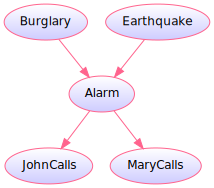

In [78]:
pgmpyToGraph(alarmModel)

$\color{MediumVioletRed}{\text{Case 1: Marginal Dependence (for Evidential Model)}}$

$$
\color{Green}{ \text{Alarm (unknown): }\;\;\;\;\;\;\;\;\; \text{JohnCalls} \longleftarrow \text{Alarm} \longleftarrow \text{MaryCalls}}
$$

When the parent node `Alarm` is unknown / unobserved, there IS an active trail between `JohnCalls` and `MaryCalls`. In other words, there is a dependence between `JohnCalls` and `MaryCalls` when `Alarm` is unobserved. This means the probability of `JohnCalls` can influence probability of `MaryCalls` (and vice versa) when information about `Alarm`'s state is unknown.

In [79]:
# **Verify:** Using Active Trails

In [80]:
assert alarmModel.is_active_trail(start = 'JohnCalls', end = 'MaryCalls',  observed = None)

showActiveTrails(model = alarmModel, variables = ['JohnCalls', 'MaryCalls'])

JohnCalls --> Burglary
JohnCalls --> Earthquake
JohnCalls --> JohnCalls
JohnCalls --> Alarm
JohnCalls --> MaryCalls
MaryCalls --> Burglary
MaryCalls --> Earthquake
MaryCalls --> JohnCalls
MaryCalls --> Alarm
MaryCalls --> MaryCalls


In [81]:
# **Verify:** Using Probabilities
# ##### Inter-Causal Reasoning For Common Cause Model:

In [82]:
JAM: DiscreteFactor = elim.query(variables = ['MaryCalls'], evidence = None)
print(JAM)

  0%|          | 0/4 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/4 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 4/4 [00:00<00:00, 1054.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/4 [00:00<?, ?it/s]    

Eliminating: Earthquake:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: Earthquake: 100%|██████████| 4/4 [00:00<00:00, 128.17it/s]

+------------------+------------------+
| MaryCalls        |   phi(MaryCalls) |
+==================+==================+
| MaryCalls(True)  |           0.6580 |
+------------------+------------------+
| MaryCalls(False) |           0.3420 |
+------------------+------------------+


In [83]:
# When John calls and no Alarm is observed, the probability of Mary calling is higher than when no call from John is observed (above).
JAM_1 = elim.query(variables = ['MaryCalls'], evidence = {'JohnCalls':'True'})
print(JAM_1)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 628.74it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/3 [00:00<?, ?it/s]     

Eliminating: Alarm: 100%|██████████| 3/3 [00:00<00:00, 145.54it/s]

+------------------+------------------+
| MaryCalls        |   phi(MaryCalls) |
+==================+==================+
| MaryCalls(True)  |           0.6975 |
+------------------+------------------+
| MaryCalls(False) |           0.3025 |
+------------------+------------------+


In [84]:
# When John does not call and no Alarm is observed, there is lower probability of Mary calling than when John does call and no alarm is observed, and than when no call from John is observed and no alarm is observed.
JAM_2 = elim.query(variables = ['MaryCalls'], evidence = {'JohnCalls':'False'})
print(JAM_2)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 221.75it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/3 [00:00<?, ?it/s]     

Eliminating: Alarm: 100%|██████████| 3/3 [00:00<00:00, 129.84it/s]

+------------------+------------------+
| MaryCalls        |   phi(MaryCalls) |
+==================+==================+
| MaryCalls(True)  |           0.4369 |
+------------------+------------------+
| MaryCalls(False) |           0.5631 |
+------------------+------------------+


In [85]:
assert (JAM.values != JAM_1.values).all() and (JAM.values != JAM_2.values).all(), "Check: Marginal Dependence: there is dependency between MaryCalls and JohnCalls, when Alarm state is unobserved "

$\color{MediumVioletRed}{\text{Case 2: Conditional Independence (for Common Cause Model)}}$

$$
\color{DeepSkyBlue}{ \text{Alarm (fixed): }\;\;\;\;\;\;\;\; \text{JohnCalls} \; \bot \; \text{MaryCalls} \; | \; \text{Alarm}}
$$
When the `Alarm`'s state is known (fixed / observed), then there is NO active trail between `JohnCalls` and `MaryCalls`. In other words, `JohnCalls` and `MaryCalls` are locally independent when `Alarm`'s state is observed. This means the probability of `JohnCalls` won't influence probability of `MaryCalls` (and vice versa) when `Alarm`'s state is observed.


In [86]:
# **Verify:** Using Active Trails

In [87]:
assert not alarmModel.is_active_trail(start = 'JohnCalls', end = 'MaryCalls', observed = 'Alarm')

showActiveTrails(model = alarmModel, variables = ['JohnCalls', 'MaryCalls'], observed = 'Alarm')

JohnCalls --> JohnCalls
MaryCalls --> MaryCalls


In [88]:
# **Verify:** Using Independencies

In [89]:
indepJohn: IndependenceAssertion = Independencies(['JohnCalls', 'MaryCalls', ['Alarm']]).get_assertions()[0]; indepJohn

indepMary: IndependenceAssertion = Independencies(['MaryCalls', 'JohnCalls', ['Alarm']]).get_assertions()[0]; indepMary


# Using the fact that closure returns independencies that are IMPLIED by the current independencies:
assert (str(indepMary) == '(MaryCalls _|_ JohnCalls | Alarm)' and
        indepMary in alarmModel.local_independencies('MaryCalls').closure().get_assertions()),  \
        "Check 1: MaryCalls and JohnCalls are independent once conditional on Alarm"

alarmModel.local_independencies('MaryCalls').closure()

(MaryCalls _|_ Burglary, Earthquake | JohnCalls, Alarm)
(MaryCalls _|_ Burglary, JohnCalls | Alarm, Earthquake)
(MaryCalls _|_ JohnCalls | Burglary, Alarm, Earthquake)
(MaryCalls _|_ Burglary, JohnCalls, Earthquake | Alarm)
(MaryCalls _|_ Earthquake | Burglary, Alarm)
(MaryCalls _|_ Burglary | JohnCalls, Alarm, Earthquake)
(MaryCalls _|_ Burglary | JohnCalls, Alarm)
(MaryCalls _|_ Burglary | Alarm)
(MaryCalls _|_ Earthquake | Alarm)
(MaryCalls _|_ Earthquake | JohnCalls, Alarm)
(MaryCalls _|_ Burglary | Alarm, Earthquake)
(MaryCalls _|_ JohnCalls | Burglary, Alarm)
(MaryCalls _|_ Burglary, Earthquake | Alarm)
(MaryCalls _|_ Earthquake | Burglary, Alarm, JohnCalls)
(MaryCalls _|_ JohnCalls, Earthquake | Burglary, Alarm)
(MaryCalls _|_ JohnCalls | Alarm)
(MaryCalls _|_ Burglary, JohnCalls | Alarm)
(MaryCalls _|_ JohnCalls | Alarm, Earthquake)
(MaryCalls _|_ JohnCalls, Earthquake | Alarm)

In [90]:
assert (str(indepJohn) == '(JohnCalls _|_ MaryCalls | Alarm)' and
        indepJohn in alarmModel.local_independencies('JohnCalls').closure().get_assertions()), \
        "Check 2: JohnCalls and MaryCalls are independent once conditional on Alarm"

alarmModel.local_independencies('MaryCalls').closure()

(MaryCalls _|_ Burglary, Earthquake | JohnCalls, Alarm)
(MaryCalls _|_ Burglary, JohnCalls | Alarm, Earthquake)
(MaryCalls _|_ JohnCalls | Burglary, Alarm, Earthquake)
(MaryCalls _|_ Burglary, JohnCalls, Earthquake | Alarm)
(MaryCalls _|_ Earthquake | Burglary, Alarm)
(MaryCalls _|_ Burglary | JohnCalls, Alarm, Earthquake)
(MaryCalls _|_ Burglary | JohnCalls, Alarm)
(MaryCalls _|_ Burglary | Alarm)
(MaryCalls _|_ Earthquake | Alarm)
(MaryCalls _|_ Earthquake | JohnCalls, Alarm)
(MaryCalls _|_ Burglary | Alarm, Earthquake)
(MaryCalls _|_ JohnCalls | Burglary, Alarm)
(MaryCalls _|_ Burglary, Earthquake | Alarm)
(MaryCalls _|_ Earthquake | Burglary, Alarm, JohnCalls)
(MaryCalls _|_ JohnCalls, Earthquake | Burglary, Alarm)
(MaryCalls _|_ JohnCalls | Alarm)
(MaryCalls _|_ Burglary, JohnCalls | Alarm)
(MaryCalls _|_ JohnCalls | Alarm, Earthquake)
(MaryCalls _|_ JohnCalls, Earthquake | Alarm)

In [91]:
# See: MaryCalls and JohnCalls are conditionally independent on Alarm:
indepSynonymTable(model = alarmModel_brief, queryNode = 'M')

                   INDEPENDENCIES TABLE                  
Fancy Notation              .....     Regular Notation   
---------------------------------------------------------
(M _|_ {J ∩ E ∩ B} | A)     .....     (M _|_ J, E, B | A)
(M _|_ {J ∩ B ∩ E} | A)     .....     (M _|_ J, B, E | A)
(M _|_ {E ∩ J ∩ B} | A)     .....     (M _|_ E, J, B | A)
(M _|_ {E ∩ B ∩ J} | A)     .....     (M _|_ E, B, J | A)
(M _|_ {B ∩ J ∩ E} | A)     .....     (M _|_ B, J, E | A)
(M _|_ {B ∩ E ∩ J} | A)     .....     (M _|_ B, E, J | A)


In [92]:
indepSynonymTable(model = alarmModel_brief, queryNode = 'J')

                   INDEPENDENCIES TABLE                  
Fancy Notation              .....     Regular Notation   
---------------------------------------------------------
(J _|_ {M ∩ E ∩ B} | A)     .....     (J _|_ M, E, B | A)
(J _|_ {M ∩ B ∩ E} | A)     .....     (J _|_ M, B, E | A)
(J _|_ {E ∩ M ∩ B} | A)     .....     (J _|_ E, M, B | A)
(J _|_ {E ∩ B ∩ M} | A)     .....     (J _|_ E, B, M | A)
(J _|_ {B ∩ M ∩ E} | A)     .....     (J _|_ B, M, E | A)
(J _|_ {B ∩ E ∩ M} | A)     .....     (J _|_ B, E, M | A)


In [93]:
# **Verify:** Using Probabilities Method

In [94]:

# Case 1: Alarm = True
JAM: DiscreteFactor = elim.query(variables = ['MaryCalls'], evidence = {'Alarm': 'True'})
JAM_1 = elim.query(variables = ['MaryCalls'], evidence = {'Alarm': 'True', 'JohnCalls':'True'})
JAM_2 = elim.query(variables = ['MaryCalls'], evidence = {'Alarm': 'True', 'JohnCalls':'False'})

assert (JAM.values == JAM_1.values).all() and (JAM.values == JAM_2.values).all(), "Check: there is independence between MaryCalls and JohnCalls when Alarm state is observed (Alarm = True)"

print(JAM)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 638.86it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/3 [00:00<?, ?it/s] 

Eliminating: JohnCalls: 100%|██████████| 3/3 [00:00<00:00, 174.10it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 547.45it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Earthquake: 100%|██████████| 2/2 [00:00<00:00, 135.72it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 715.69it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Earthquake: 100%|██████████| 2/2 [00:00<00:00, 147.84it/s]

+------------------+------------------+
| MaryCalls        |   phi(MaryCalls) |
+==================+==================+
| MaryCalls(True)  |           0.7000 |
+------------------+------------------+
| MaryCalls(False) |           0.3000 |
+------------------+------------------+


In [95]:

# Case 2: Alarm = False
JAM: DiscreteFactor = elim.query(variables = ['MaryCalls'], evidence = {'Alarm': 'False'})
JAM_1 = elim.query(variables = ['MaryCalls'], evidence = {'Alarm': 'False', 'JohnCalls':'True'})
JAM_2 = elim.query(variables = ['MaryCalls'], evidence = {'Alarm': 'False', 'JohnCalls':'False'})

assert (JAM.values == JAM_1.values).all() and (JAM.values == JAM_2.values).all(), "Check: there is independence between MaryCalls and JohnCalls when Alarm state is observed (Alarm = False)"

print(JAM)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 538.70it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/3 [00:00<?, ?it/s] 

Eliminating: JohnCalls: 100%|██████████| 3/3 [00:00<00:00, 208.66it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 334.25it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Earthquake: 100%|██████████| 2/2 [00:00<00:00, 153.70it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 301.79it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Earthquake: 100%|██████████| 2/2 [00:00<00:00, 265.86it/s]

+------------------+------------------+
| MaryCalls        |   phi(MaryCalls) |
+==================+==================+
| MaryCalls(True)  |           0.0100 |
+------------------+------------------+
| MaryCalls(False) |           0.9900 |
+------------------+------------------+


In [96]:
# Symmetry:
MAJ: DiscreteFactor = elim.query(variables = ['JohnCalls'], evidence = {'Alarm': 'False'})
MAJ_1 = elim.query(variables = ['JohnCalls'], evidence = {'Alarm': 'False', 'MaryCalls':'True'})
MAJ_2 = elim.query(variables = ['JohnCalls'], evidence = {'Alarm': 'False', 'MaryCalls':'False'})

assert (MAJ.values == MAJ_1.values).all() and (MAJ.values == MAJ_2.values).all(), "Check: there is independence between MaryCalls and JohnCalls when Alarm state is observed (Alarm = False)"

print(MAJ)




  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 558.99it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Earthquake: 100%|██████████| 3/3 [00:00<00:00, 171.54it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 580.57it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Earthquake: 100%|██████████| 2/2 [00:00<00:00, 151.21it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 267.19it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Earthquake:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: Earthquake: 100%|██████████| 2/2 [00:00<00:00, 177.68it/s]

+------------------+------------------+
| JohnCalls        |   phi(JohnCalls) |
+==================+==================+
| JohnCalls(True)  |           0.0500 |
+------------------+------------------+
| JohnCalls(False) |           0.9500 |
+------------------+------------------+


In [97]:
# ### 4. Inter-Causal Reasoning in the Alarm Model
# For a common evdience model $A \rightarrow B \leftarrow C$, there are two cases:
#   * **Marginal Independence:** ($B$ unknown): When $B$ is unknown / unobserved, there is NO active trail between $A$ and $C$; they are independent. The probability of $A$ won't influence probability of $C$ (and vice versa) when $B$'s state is unknown.
#   * **Conditional Dependence:** ($B$ fixed): When $B$ is fixed, there IS an active trail between $A$ and $C$, meaning the probability of $A$ can influence probability of $C$ (and vice versa) when information about $B$ is observed / fixed.

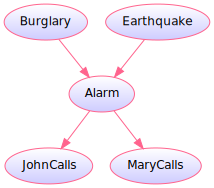

In [98]:
pgmpyToGraph(alarmModel)

$\color{MediumVioletRed}{\text{Case 1: Marginal Independence (for Common Evidence Model)}}$

$$
\color{DeepSkyBlue}{ \text{Alarm (fixed): }\;\;\;\;\;\;\;\; \text{Burglary} \; \bot \; \text{Earthquake} \; | \; \text{Alarm}}
$$

When the effect node `Alarm` is unknown / unobserved, there is NO an active trail between `Burglary` and `Earthquake`. In other words, there is a local marginal independence between `Burglary` and `Earthquake` when `Alarm` is unobserved. This means the probability of `Burglary` won't influence the probability of `Earthquake` (and vice versa) when `Alarm`'s state is unknown.


In [99]:
# **Verify:** Using Active Trails

In [100]:
assert not alarmModel.is_active_trail(start = 'Burglary', end = 'Earthquake', observed = None)

showActiveTrails(model = alarmModel, variables = ['Burglary', 'Earthquake'])

Burglary --> Burglary
Burglary --> Alarm
Burglary --> MaryCalls
Burglary --> JohnCalls
Earthquake --> JohnCalls
Earthquake --> Alarm
Earthquake --> MaryCalls
Earthquake --> Earthquake


In [101]:
# **Verify:** Using Independencies

In [102]:
indepBurgEarth = Independencies(['Burglary', 'Earthquake'])

assert indepBurgEarth == alarmModel.local_independencies('Burglary'), 'Check 1: Burglary and Earthquake are marginally independent'

assert indepBurgEarth == alarmModel.local_independencies('Earthquake'), 'Check 2: Burglary and Earthquake are marginally independent'


# See: MaryCalls and Burglary are marginally independent :
print(indepSynonymTable(model = alarmModel, queryNode = 'Burglary'))
print(indepSynonymTable(model = alarmModel, queryNode = 'Earthquake'))

                       INDEPENDENCIES TABLE                      
Fancy Notation                .....     Regular Notation         
-----------------------------------------------------------------
(Burglary _|_ Earthquake)     .....     (Burglary _|_ Earthquake)
None
                       INDEPENDENCIES TABLE                      
Fancy Notation                .....     Regular Notation         
-----------------------------------------------------------------
(Earthquake _|_ Burglary)     .....     (Earthquake _|_ Burglary)
None


In [103]:
# **Verify:** Using Probabilities Method

In [104]:

BAE: DiscreteFactor = elim.query(variables = ['Earthquake'], evidence = None)
BAE_1 = elim.query(variables = ['Earthquake'], evidence = {'Burglary':'True'})
BAE_2 = elim.query(variables = ['Earthquake'], evidence = {'Burglary': 'False'})

# Using np.allclose instead of exact equals sign (there must be some numerical inconsistency ... otherwise they wouldn't be different at all! BAE.values[0] = 0.0019999999 while BAE_1.values[0] = 0.002)
assert np.allclose(BAE.values, BAE_1.values) and np.allclose(BAE.values, BAE_2.values), "Check: there is marginal independence between Earthquake and Burglary when Alarm state is NOT observed"

print(BAE)



  0%|          | 0/4 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/4 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 4/4 [00:00<00:00, 573.21it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/4 [00:00<?, ?it/s]    

Eliminating: JohnCalls:   0%|          | 0/4 [00:00<?, ?it/s]

Eliminating: JohnCalls: 100%|██████████| 4/4 [00:00<00:00, 176.62it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 543.16it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/3 [00:00<?, ?it/s]    

Eliminating: JohnCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: JohnCalls: 100%|██████████| 3/3 [00:00<00:00, 152.83it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 515.42it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Alarm:   0%|          | 0/3 [00:00<?, ?it/s]    

Eliminating: JohnCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: JohnCalls: 100%|██████████| 3/3 [00:00<00:00, 142.46it/s]

+-------------------+-------------------+
| Earthquake        |   phi(Earthquake) |
+===================+===================+
| Earthquake(True)  |            0.0020 |
+-------------------+-------------------+
| Earthquake(False) |            0.9980 |
+-------------------+-------------------+


$\color{MediumVioletRed}{\text{Case 2: Conditional Dependence (for Common Evidence Model)}}$

$$
\color{Green}{ \text{Alarm (unknown): }\;\;\;\;\;\;\;\;\; \text{Burglary} \longleftarrow \text{Alarm} \longrightarrow \text{Earthquake}}
$$
When the `Alarm`'s state is known (fixed / observed), then there IS an active trail between `Burglary` and `Earthquake`. In other words, `Burglary` and `Earthquake` are dependent when `Alarm`'s state is observed. This means the probability of `Burglary` can influence probability of `Earthquake` (and vice versa) when `Alarm`'s state is observed.

In [105]:
# **Verify:** Using Active Trails

In [106]:
assert alarmModel.is_active_trail(start = 'Burglary', end = 'Earthquake',  observed = 'Alarm')

showActiveTrails(model = alarmModel, variables = ['Burglary', 'Earthquake'], observed = 'Alarm')

Burglary --> Burglary
Burglary --> Earthquake
Earthquake --> Burglary
Earthquake --> Earthquake


In [107]:
# **Verify:** Using Probabilities
# ##### Inter-Causal Reasoning For Common Evidence Model:

In [108]:

# Case 1: Alarm = True
BAE: DiscreteFactor = elim.query(variables = ['Earthquake'], evidence = {'Alarm': 'True'})
print(BAE)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 656.15it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: JohnCalls: 100%|██████████| 3/3 [00:00<00:00, 350.78it/s]

+-------------------+-------------------+
| Earthquake        |   phi(Earthquake) |
+===================+===================+
| Earthquake(True)  |            0.0020 |
+-------------------+-------------------+
| Earthquake(False) |            0.9980 |
+-------------------+-------------------+


In [109]:
BAE_1: DiscreteFactor = elim.query(variables = ['Earthquake'], evidence = {'Burglary':'True', 'Alarm': 'True'})
print(BAE_1)

  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 677.54it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls: 100%|██████████| 2/2 [00:00<00:00, 492.93it/s]

+-------------------+-------------------+
| Earthquake        |   phi(Earthquake) |
+===================+===================+
| Earthquake(True)  |            0.0020 |
+-------------------+-------------------+
| Earthquake(False) |            0.9980 |
+-------------------+-------------------+


In [110]:
# When there was no burglary and alarm did ring, then there is higher probability of earthquake than when there was a burglary and alarm did ring, or when there was no burglary observed but alarm did ring.
BAE_2: DiscreteFactor = elim.query(variables = ['Earthquake'], evidence = {'Burglary':'False', 'Alarm': 'True'})
print(BAE_2)

  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 835.44it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls: 100%|██████████| 2/2 [00:00<00:00, 479.60it/s]

+-------------------+-------------------+
| Earthquake        |   phi(Earthquake) |
+===================+===================+
| Earthquake(True)  |            0.3676 |
+-------------------+-------------------+
| Earthquake(False) |            0.6324 |
+-------------------+-------------------+


In [111]:
assert (BAE_2.values != BAE.values).all(), 'Check: there is dependency between Earthquake and Burglary when Alarm state is observed (True)'

In [112]:
# Case 2: Alarm = False
BAE: DiscreteFactor = elim.query(variables = ['Earthquake'], evidence = {'Alarm': 'False'})
print(BAE)

  0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/3 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 3/3 [00:00<00:00, 1082.21it/s]


  0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: Burglary:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/3 [00:00<?, ?it/s]

Eliminating: JohnCalls: 100%|██████████| 3/3 [00:00<00:00, 223.36it/s]

+-------------------+-------------------+
| Earthquake        |   phi(Earthquake) |
+===================+===================+
| Earthquake(True)  |            0.0017 |
+-------------------+-------------------+
| Earthquake(False) |            0.9983 |
+-------------------+-------------------+


In [113]:
BAE_1: DiscreteFactor = elim.query(variables = ['Earthquake'], evidence = {'Burglary':'True', 'Alarm': 'False'})
print(BAE_1)

  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 1005.11it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls: 100%|██████████| 2/2 [00:00<00:00, 585.96it/s]

+-------------------+-------------------+
| Earthquake        |   phi(Earthquake) |
+===================+===================+
| Earthquake(True)  |            0.0017 |
+-------------------+-------------------+
| Earthquake(False) |            0.9983 |
+-------------------+-------------------+


In [114]:
# When there is no burglary and alarm does NOT ring, then there is lower probability of earthquake than when there was a burglary and alarm did not ring, or when there was no burglary observed and alarm didn't ring.
BAE_2: DiscreteFactor = elim.query(variables = ['Earthquake'], evidence = {'Burglary':'False', 'Alarm': 'False'})
print(BAE_2)

  0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: :   0%|          | 0/2 [00:00<?, ?it/s]

Finding Elimination Order: : 100%|██████████| 2/2 [00:00<00:00, 811.75it/s]


  0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: JohnCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls:   0%|          | 0/2 [00:00<?, ?it/s]

Eliminating: MaryCalls: 100%|██████████| 2/2 [00:00<00:00, 642.41it/s]

+-------------------+-------------------+
| Earthquake        |   phi(Earthquake) |
+===================+===================+
| Earthquake(True)  |            0.0014 |
+-------------------+-------------------+
| Earthquake(False) |            0.9986 |
+-------------------+-------------------+


In [115]:
assert (BAE_2.values != BAE.values).all(), 'Check: there is dependency between Earthquake and Burglary when Alarm state is observed (False)'






In [116]:
# 2. Evidential Reasoning
# 3. Intercausal Reasoning
#   * Given: Mary calls, Alarm rang, John id not call --> M = True, A = True, J = False
#   * Find: probability of earthquake: P(E = True | M = True, A = True, J = False)





In [117]:
# -----------------
# $I = 1, D = 1, S = 1$, and then marginalize over the other variables we didn't ask about (L) to get the distribution for the variable we asked about (G), so to get the distribution: $P(G \; | \; I = 1, D = 1, S = 1)$.
#
# But doing marginalize and reduce operations on the complete Joint Distribution is computationally expensive since we need to iterate over the whole table for each operation and the table is exponential in size to the number of variables. But we can exploit the independencies (like above) to break these operations in smaller parts, increasing efficiency of calculation.
#
# ### Variable Elimination
# **Variable Elimination:** a method of inference in graphical models.
#
# For our model, we know that the joint distribution (reduced using local independencies) is:
# $$
# \begin{align}
# P(D, I, G, L, S) = P(L \; | \; G) \cdot P(S \; | \; I) \cdot P(G \; | \; D, I) \cdot P(D) \cdot P(I)
# \end{align}
# $$
# **Example 1: Compute $P(G)$**
#
# Now say we want to compute the probability of just the grade $G$. That means we must **marginalize** over all other variables:
# $$
# \begin{align}
# P(G) &= \sum_{D,I,L,S} P(D,I,G,L,S) \\
# &= \sum_{D,I,L,S} P(L \; | \; G) \cdot P(S \; | \; I) \cdot P(G \; | \; D, I) \cdot P(D) \cdot P(I) \\
# &= \sum_D \sum_I \sum_L \sum_S P(L \; | \; G) \cdot P(S \; | \; I) \cdot P(G \; | \; D, I) \cdot P(D) \cdot P(I) \\
# &= \sum_D P(D) \sum_I P(G \; | \; D, I) \cdot P(I) \sum_S P(S \; | \; I) \sum_L P(L \; | \; G)
# \end{align}
# $$
# In the above expression, to simplify the sumation, we just brought the summation with respect to a particular variable as far as it could go (as inner-deep as it could go, without putting the summation with respect to the variable past the probability expression that included that variable)
#
# By pushing the summations inside we have saved a lot of computation because we now have to iterate over much smaller tables.


# TODO do the different kinds of inference from (Korb book): intercausal, diagnostic ... etc